In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# LOADING DATA AND DATA PRE-PROCESSING

In [2]:
def get_data():
    #Loading Data
    test_dataframe = pd.read_csv(r"D:\Projects\Basic ML Models\Tensorcraft MNIST\emnist-mnist-test.csv")
    train_dataframe = pd.read_csv(r"D:\Projects\Basic ML Models\Tensorcraft MNIST\emnist-mnist-train.csv")

    #Data cleaning and pre-processing
    t_labels = test_dataframe.iloc[:, 0]
    t_images = test_dataframe.iloc[:, 1:]

    te_labels = train_dataframe.iloc[:, 0]
    te_images = train_dataframe.iloc[:, 1:]

    #reshaping to 2d 
    t_images = t_images.values.reshape(-1, 28, 28)
    te_images = te_images.values.reshape(-1, 28, 28)

    #print(t_images) #testsass
    #normalization
    t_images = t_images / 255.0
    te_images = te_images / 255.0

    #print(t_images) #testass
    #checking for non blank images to remove and clean the dataset daddyyyyyy
    t_non_blank = np.any(t_images != 0, axis=(1, 2))  
    te_non_blank = np.any(te_images != 0, axis=(1, 2))  

    
    t_images = t_images[t_non_blank]  
    t_labels = t_labels[t_non_blank]

    te_images = te_images[te_non_blank]
    te_labels = te_labels[te_non_blank]

    #print(t_images) #testass
    return t_labels,t_images,te_labels,te_images

# VISUALIZING DATA


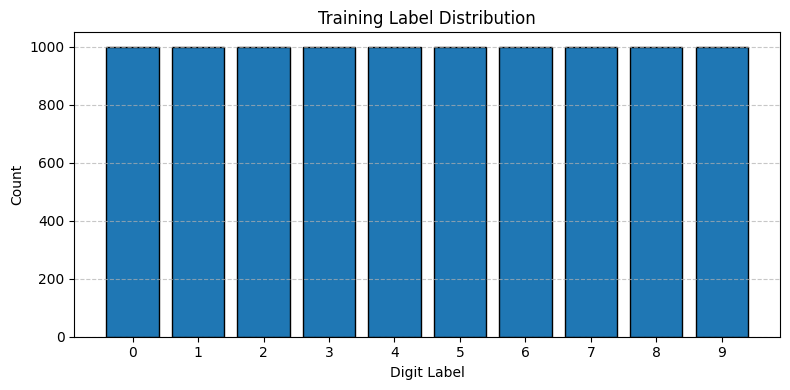

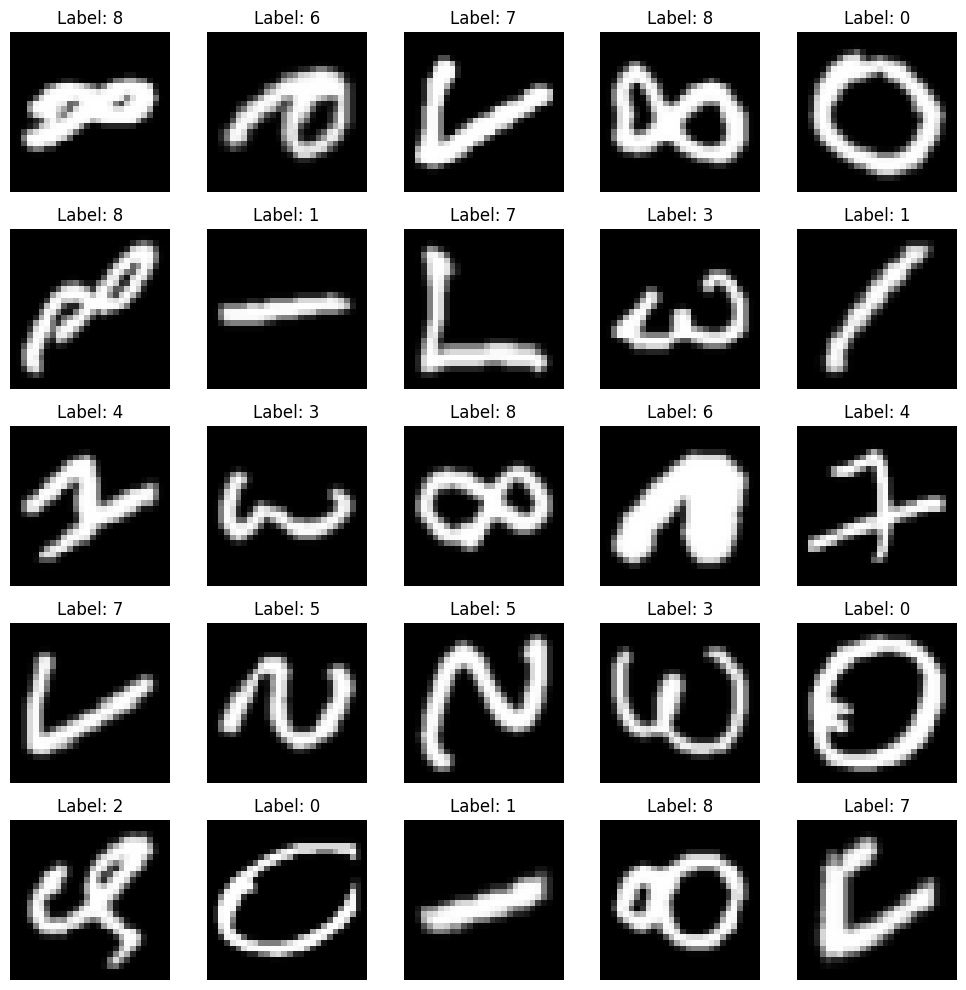

In [13]:
def plot_class_distribution(labels, title="Label Distribution"):
    plt.figure(figsize=(8, 4))
    plt.hist(labels, bins=np.arange(11) - 0.5, rwidth=0.8, edgecolor='black')
    plt.xticks(np.arange(10))
    plt.xlabel("Digit Label")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def visualize_images(images, labels, n=5):
    fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
    for i in range(n * n):
        ax = axs[i // n, i % n]
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()



train_labels, train_images, test_labels, test_images = get_data()
plot_class_distribution(train_labels, "Training Label Distribution")
visualize_images(train_images, train_labels)

# ACTIVATION FUNCTIONS

Relu activation

In [4]:
def relu(x):
    return jnp.maximum(0, x)

Relu derivative

In [5]:
def relu_derivative(x):
    return (x > 0).astype(jnp.float32)

Softmax

In [6]:
def softmax(x):
    exp_x = jnp.exp(x - jnp.max(x, axis=1, keepdims=True))
    return exp_x / jnp.sum(exp_x, axis=1, keepdims=True)


# NEURAL NETWORK 

Initializing Neural Network

In [7]:
def initialize_nn(inputt, hidden, output):
    key = jax.random.PRNGKey(42)
    key, k1, k2, k3, k4, k5 = jax.random.split(key, 6)
    scale_inp = jnp.sqrt(2.0 / inputt)
    scale_hid = jnp.sqrt(2.0 / hidden)
    weights = {
        "weight1": jax.random.normal(k1, (inputt, hidden)) * scale_inp,
        "biasvect1": jnp.zeros((1, hidden)),
        
        "weight2": jax.random.normal(k2, (hidden, hidden)) * scale_hid,
        "biasvect2": jnp.zeros((1, hidden)),
        
        "weight3": jax.random.normal(k3, (hidden, output)) * scale_hid,
        "biasvect3": jnp.zeros((1, output)),
        
        "weight_skip": jax.random.normal(k4, (inputt, hidden)) * scale_inp,
        "biasvect_skip": jnp.zeros((1, hidden))
    }
    return weights

Forward Propogation

In [8]:
def forward_propagation(X, weights):

    #z = intermediate values, a = activation values
    Z1 = jnp.dot(X, weights["weight1"]) + weights["biasvect1"]
    A1 = relu(Z1)
    #print(f"Shape of A1: {A1.shape}")  #tetsass
    
    Z2 = jnp.dot(A1, weights["weight2"]) + weights["biasvect2"]
    skip_connection = jnp.dot(X, weights["weight_skip"]) + weights["biasvect_skip"]
    A2 = relu(Z2 + skip_connection)
    
    Z3 = jnp.dot(A2, weights["weight3"]) + weights["biasvect3"]
    A3 = softmax(Z3)

    cache = {"A1": A1, "A2": A2, "A3": A3, "skip": skip_connection,"Z1":Z1,"Z2":Z2,"Z3":Z3}
    return A3, cache

Back Propogation

In [9]:
def backpropagation(X, Y, weights, cache, learn_rate=0.01):
    m = X.shape[0]
    Y_onehot = jnp.eye(weights["biasvect3"].shape[1])[Y]
    
    #dz = gradient of loss wrt z, da = gradient of loss wrt a
    dZ3 = cache["A3"] - Y_onehot
    dW3 = jnp.dot(cache["A2"].T, dZ3) / m
    db3 = jnp.sum(dZ3, axis=0, keepdims=True) / m
    
    dA2 = jnp.dot(dZ3, weights["weight3"].T)
    dZ2 = dA2 * relu_derivative(cache["A1"])
    dW2 = jnp.dot(cache["A1"].T, dZ2) / m
    db2 = jnp.sum(dZ2, axis=0, keepdims=True) / m
    
    dskip = dA2
    dW_skip = jnp.dot(X.T, dskip) / m
    db_skip = jnp.sum(dskip, axis=0, keepdims=True) / m
    
    dA1 = jnp.dot(dZ2, weights["weight2"].T)
    dZ1 = dA1 * relu_derivative(cache["Z1"])
    dW1 = jnp.dot(X.T, dZ1) / m
    db1 = jnp.sum(dZ1, axis=0, keepdims=True) / m

    #print(f"dW1 shape: {dW1.shape}, db1 shape: {db1.shape}")
    weights["weight1"] -= learn_rate * dW1
    weights["biasvect1"] -= learn_rate * db1
    weights["weight2"] -= learn_rate * dW2
    weights["biasvect2"] -= learn_rate * db2
    weights["weight3"] -= learn_rate * dW3
    weights["biasvect3"] -= learn_rate * db3
    weights["weight_skip"] -= learn_rate * dW_skip
    weights["biasvect_skip"] -= learn_rate * db_skip
    
    return weights

# TRAINING THE DATASET

In [20]:
def train(X_batch_train, Y_batch_train, weights, epochs=10, batch_length=64, learn_rate=0.01):
    for epoch in range(epochs):
        for i in range(0, X_batch_train.shape[0], batch_length):
            X_train_batch = X_batch_train[i:i+batch_length]
            Y_train_batch = Y_batch_train[i:i+batch_length]

            A3, cache = forward_propagation(X_train_batch, weights)
            weights = backpropagation(X_train_batch, Y_train_batch, weights, cache, learn_rate)

        if epoch % 2 == 0:
            A3, _ = forward_propagation(X_batch_train, weights)
            t_preds = jnp.argmax(A3, axis=1)
            t_accuracy = jnp.mean(t_preds == Y_batch_train)
            print(f"Epoch {epoch}, Training Accuracy: {t_accuracy:.4f}")
            num_of_classes = jnp.max(Y_batch_train) + 1
            a = jnp.zeros((num_of_classes, num_of_classes))
            for true, pred in zip(Y_batch_train, t_preds):
                a = a.at[true, pred].add(1)
            # Precision things
            b = jnp.diag(a)
            c = jnp.sum(a, axis=0) - b
            precision = b/ (b + c + 1e-10)

            #recall and f1 score
            d = jnp.sum(a, axis=1) - b
            recall = b/ (b + d + 1e-10)
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

            print(f"  Precision: {precision.mean():.4f}")
            print(f"  F1 Score: {f1_score.mean():.4f}")
            print("-" * 40)

    return weights

# TESTING THE DATASET FUNCTION

In [21]:
def test_accuracy(X_test_batch, Y_test_batch, weights):
    A3, _ = forward_propagation(X_test_batch, weights)
    test_preds = jnp.argmax(A3, axis=1)
    test_accuracy = jnp.mean(test_preds == Y_test_batch)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    num_of_classes = jnp.max(Y_test_batch) + 1
    a = jnp.zeros((num_of_classes, num_of_classes))
    for true, pred in zip(Y_test_batch, test_preds):
        a = a.at[true, pred].add(1)
    # Precision things
    b = jnp.diag(a)
    c = jnp.sum(a, axis=0) - b
    precision = b/ (b + c + 1e-10)
    
    #recall and f1 score
    d = jnp.sum(a, axis=1) - b
    recall = b/ (b + d + 1e-10)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
    print(f"  Precision: {precision.mean():.4f}")
    print(f"  F1 Score: {f1_score.mean():.4f}")

# MAIN EXECUTION

In [12]:
t_labels, t_images, te_labels, te_images = get_data()

X_train_batch = te_images.reshape(te_images.shape[0], -1)    
X_test_batch = t_images.reshape(t_images.shape[0], -1)
Y_train_batch = te_labels.to_numpy()
Y_test_batch = t_labels.to_numpy()
inputtsz = X_train_batch.shape[1]
hiddensz = 128
outputsz = jnp.unique(Y_train_batch).shape[0]
weights = initialize_nn(inputtsz, hiddensz, outputsz)
weights = train(X_train_batch, Y_train_batch, weights, epochs=10, batch_length=64, learn_rate=0.01)
test_accuracy(X_test_batch, Y_test_batch, weights)

Epoch 0, Training Accuracy: 0.9061
  Precision: 0.9061
  F1 Score: 0.9059
----------------------------------------
Epoch 2, Training Accuracy: 0.9317
  Precision: 0.9319
  F1 Score: 0.9317
----------------------------------------
Epoch 4, Training Accuracy: 0.9421
  Precision: 0.9424
  F1 Score: 0.9421
----------------------------------------
Epoch 6, Training Accuracy: 0.9490
  Precision: 0.9493
  F1 Score: 0.9490
----------------------------------------
Epoch 8, Training Accuracy: 0.9551
  Precision: 0.9553
  F1 Score: 0.9551
----------------------------------------
Test Accuracy: 0.9530
  Precision: 0.9532
  F1 Score: 0.9530
